# 背景概述

$\quad$人的 (生物学) 性别由染色体上的若干基因决定. 本次上机作业中, 我们使用[GTEx组织基因表达数据库](https://www.gtexportal.org/home/downloads/adult-gtex/bulk_tissue_expression)中的人脑杏仁核 (amygdala) 数据子集, 应用Logistic回归模型, 从基因片段表达量出发, 预测测序样本对应被试的性别.

$\quad$在生物信息学中, 基因表达量常以[TPM (Transcript Per kilobase Million)](https://www.rna-seqblog.com/rpkm-fpkm-and-tpm-clearly-explained/) 进行记录. 给定被测样本$S$和基因片段$G$, 则TPM可由下述公式计算:
$$
\mathrm{TPM}(G; S) = 10^6 \frac{\mathrm{RPK}(G; S)}{\sum_G{\mathrm{RPK}(G; S)}},
$$
其中, **RPK (Reads Per Kilobase)** 是将样本$S$中 **基因$G$的表达 (转录) 计数值 (reads)** 按长度 (单位是 **千碱基 (kilobase, kb)** ) 做了归一化:
$$
\mathrm{RPK} (G; S) = \frac{\mathrm{ReadCount}(G; S)}{\mathrm{KbLength}(G)}.
$$
- 简言之, 基因$G$在测序样本$S$中的TPM值越高 (或说, RPK越高), 则基因$G$在$S$中的表达越"活跃".

# 数据的读取与清洗

$\quad$在数据文件`GTEx_gene_amygdala_tpm_v8.gct`中, 存有56200条基因片段在154名被测人员体内的TPM值.
- GTEx数据库给每份被测样本提供了[格式化的编码](https://gtexportal.org/home/faq#sampleIdFormat), 其中包括被测样本的供体 (人员) 编号`donor ID`;
- 我们将根据该文件中的测序数据预测供体人员的性别, 而这些供体人员 (包括性别在内) 的各种信息存于数据文件`subject_pheontypes_v8.txt`中.

## 基因测序数据

$\quad$**任务1**: 在`src/data.py`文件中编写相应函数, 从`.gct`格式文件中读取测序数据, 并完成训练-测试拆分与归一化.
- **任务1.1**: 编写函数`read_gct()`, 完成原始数据的读取.
  - 输入: 数据文件名`gct_fname`.
  - 返回: 读取完的数据`raw_data`, 格式为`pd.DataFrame`. 要求:
    - 以名称列`Name`作为表格索引, 以备后续检索性别时使用.
    - 先将`id`和`Description`两列从原表格中删除, 再将原表格 **转置**.
- **任务1.2**: 编写函数`normalize_tpms()`, 完成 (拆分后的) 原始数据的与归一化.
  - 输入:
    - 训练集`X_train`与测试集`X_test`;
    - 归一化方法`method`, 仅接受两个可能值: `'minmax'`和`'standard'`, 分别代表**最小-最大**归一化和**均值-方差**归一化.
  - 返回: 经过归一化处理的`X_train_normalized`以及其它数据集`others_normalized`(以列表打包起来). **为了和[`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)或[`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler)保持一致, 请确保返回值均为`np.array`格式**, 例如对某`DataFrame`类型的变量`df`使用格式转换`np.array(df)`.

### 提示
- [GCT](https://clue.io/connectopedia/pdf/gct_format)是一种常用的测序数据文件记录格式, 大致如下:
```
#(version string)
(data row count) (tab) (data column count) (tab) (row metadata field count) (tab) (column metadata field count)
Name (tab) Description (tab) (sample 1 name) (tab) ...
(gene 1 name) (tab) (gene 1 description) (tab) (TPM of sample 1 on gene 1) (tab) ...
```
例如: 本例的数据文件`GTEx_gene_amygdala_tpm_v8.gct`的前4行为
```
#1.3
56200	154	0	0
id	Name	Description	GTEX-11NUK-0011-R4a-SM-DO12B	GTEX-11ONC-0011-R4b-SM-DO93H ...
0	ENSG00000223972.5	DDX11L1	0.0718	0.0000 ...
```
- 在编写函数`read_gct`时, 你需要从[`pd.read_csv()`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html#pandas.read_csv)函数中仔细地寻找你需要的特定参数, 以适应`.gct`数据格式. 这里需要额外指定的参数包括分隔符`sep`和跳过的行数`skiprows`.
  - CSV文件的全称是[Comma-Separated Values](https://en.wikipedia.org/wiki/Comma-separated_values), 所以, `pd.read_csv()`函数默认采用的数据分隔符是逗号`','`. 但GCT文件采用制表符`'\t'`作为分隔符.
  - 我们需要第3行的内容作为`DataFrame`的列索引, 而正式记录的数据从第4行开始. 前两行是非格式化的, 且并非我们必须读入的信息.
- `.gct`文件每行记录一个特定的基因名(特征), 每列记录一个被试试验 (被试性别的数据将从另外渠道读取). 根据`sklearn`的数据矩阵格式要求, 需要用[`transpose()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.transpose.html#pandas.DataFrame.transpose)方法取原表格的转置.
- 被试基因样本的编号储存在`Name`列中, 你需要使用[`set_index()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.set_index.html#pandas.DataFrame.set_index)方法将它设置为索引列, 以便和另一个数据表格中的性别信息对接.

$\quad$完成任务1后, 可以运行下面的代码块进行初步测试.

In [1]:
!pytest -v -s tests/test_normalize.py

============================= test session starts =============================
platform win32 -- Python 3.12.10, pytest-8.4.2, pluggy-1.6.0 -- C:\Users\track\AppData\Local\Programs\Python\Python312\python.exe
cachedir: .pytest_cache
rootdir: d:\Work\Chemistry\课程\机器学习及其在化学中的应用\Homework\hw2
collecting ... collected 4 items

tests/test_normalize.py::test_standardscale_train PASSED
tests/test_normalize.py::test_standardscale_consistency PASSED
tests/test_normalize.py::test_minmaxscale_train PASSED
tests/test_normalize.py::test_minmaxscale_consistency PASSED

============================== 4 passed in 2.79s ==============================


## 供体性别数据

$\quad$我们已经为你准备好相关代码, 根据`.gct`数据中的被测供体编号, 从`subject_pheontypes_v8.txt`中提取对应的性别信息. 原始数据以1标记男性 (male)、2标记女性 (female), 这里改用0标记男性、1标记女性, 和Logistic回归模型的0-1分类习惯一致. 请运行下述两个代码块, 读取被测供体的性别数据.

$\quad$**任务2**: 轻松一下! 运行下面的代码块, 导出供体的性别比例饼图.

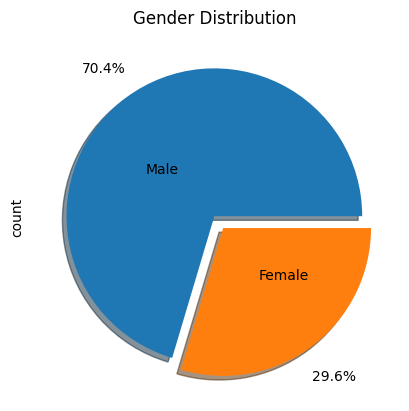

In [2]:
from src.data import read_gct, get_gender

gct = read_gct('data/GTEx_gene_amygdala_tpm_v8.gct')
gender = get_gender('data/subject_pheontypes_v8.txt', gtex_ids=list(gct.index))

_ = gender.value_counts().plot(
    title='Gender Distribution',
    kind='pie',
    labels=['Male', 'Female'],
    autopct='%1.1f%%',
    pctdistance=1.25,
    labeldistance=0.4,
    shadow=True,
    explode=[0, 0.1]
)
_.figure.savefig('results/gender_pieplot.png')

# 模型的训练与评估

$\quad$我们下面搭建Logistic回归模型, 并逐步完成模型训练与评估的全部流程.

$\quad$**任务3**: 模型训练与评估组件的搭建.
- **任务3.1**: 编写函数`evaluate_model()`, 实现模型评估.
  - 输入:
    - 真实标签构成的列表`y_trues`、预测标签构成的列表`y_preds`、预测概率分值构成的列表`y_probas`;
    - 图例标注构成的列表`labels`;
    - `plot`: `bool`值参数 (默认为`True`), 表征在调用该函数是否作ROC曲线;
    - `save_path`: 若需要绘制ROC曲线时的存储路径.
  - 返回: 以字典形式返回各个数据集上的分类指标. 示例:
  ```
  Input parameters:
      evaluate_model(
          y_trues=[y_true_train, y_true_test],
          y_preds=[y_pred_train, y_pred_test],
          y_probas=[y_proba_train, y_proba_test],
          labels=['train', 'test'],
          plot=True
      )
  Returned value:
      {
          'accuracy': [accuracy_train, accuracy_test],
          'precision': [precision_train, precision_test],
          'recall': [recall_train, recall_test],
          'f1': [f1_train, f1_test]
      }
  ```
  - 需实现的其它功能:
    - 如果`plot=True`, 则要求该函数能够应用函数`plot_roc()` (参见上机实习2, 以下已给出) 绘制各个数据集上的ROC曲线, 并以图例的形式报告对应的AUC值.

- **任务3.2**: 编写函数`train_and_eval()`, 建立模型训练与评估的工作流.
  - 输入:
    - 训练与验证数据集: `X_train, X_val, y_true_train, y_true_val`;
    - 是否在评估时进行ROC作图的逻辑参数`plot`;
    - 用于构建Logistic回归模型的超参数字典`hyperparams`.
  - 返回:
    - 训练好的模型`clf`;
    - 对应的评估指标字典`metrics`.

- **任务3.3**: 结合评估结果与TPM的定义, 比较两种归一化方法的优劣 (哪一种能够较好地提取TPM中的有效信息): (a) 最小-最大归一化; (b) 均值-方差归一化.

### 提示
- 对字典使用`**`运算符, 可以将其作为一组[关键词参数 (kwargs)](https://www.pythontutorial.net/python-basics/python-kwargs/) 传入特定函数. 例如:
```python
def train_model(X_train: np.array, y_true_train: np.array, hyperparams: Dict) -> object:
    return LogisticRegression(**hyperparams).fit(X_train, y_true_train)
```
- 注意[`predict_proba()`](https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba)方法将对每条数据返回一个二元元组, 我们需要的是第二个值 (即让模型决策为`1`而非`0`的那个概率).

$\quad$完成任务3.1后, 可以运行下面的代码块对该函数进行初步测试.

In [3]:
!pytest -v -s tests/test_eval.py

============================= test session starts =============================
platform win32 -- Python 3.12.10, pytest-8.4.2, pluggy-1.6.0 -- C:\Users\track\AppData\Local\Programs\Python\Python312\python.exe
cachedir: .pytest_cache
rootdir: d:\Work\Chemistry\课程\机器学习及其在化学中的应用\Homework\hw2
collecting ... collected 2 items

tests/test_eval.py::test_evaluate_model_keys PASSED
tests/test_eval.py::test_evaluate_model_values PASSED

============================== 2 passed in 3.72s ==============================


### 提示
$\quad$每完成一个子任务后, 你都可以运行下述代码块, 执行脚本文件`hw2.py`以检查输出. 完成任务3.1-3.3后, 请再运行一次下述代码块, 并在`results`目录下检查你的输出结果.

In [4]:
!python hw2.py --data-dir data/ --output-dir results/ --test-size 0.2 --random-state 0

# 结果分析: 对性别预测起决定作用的基因片段

**任务4**: 运行下述四个代码块, 根据Logistic回归模型系数, 筛选出对性别预测作用最大的5个基因片段.
- **问题4.1**: 筛选出系数最小 (最"负") 的5个系数所对应的基因名, 并自行检索相关信息. 它们大多定位在哪条染色体上?
- **挑战问题1**: 筛选出系数最大 (最"正") 的5个系数所对应的基因名, 并自行检索相关信息. 系数最大的那个基因片段如何与对应性别相关联?
- **挑战问题2**: 某同学根据数据得出结论: **系数 (绝对) 值最大的5个基因片段对性别起决定作用**. 从生物学机制的角度, 这句话不一定合理, 为什么?

### 提示
- 为了回答问题4.1和挑战问题1, 你可能需要检索一些基因组数据库, 例如 [Ensembl](https://www.ensembl.org/index.html)与[HGNC](https://www.genenames.org/).
- 为了回答挑战问题1, 你可能需要一些[参考文献](https://pubmed.ncbi.nlm.nih.gov/16146776/)与[参考资料](https://en.wikipedia.org/wiki/X-inactivation).
- 为了回答挑战问题2, 以下是一些帮助你思考的提示:
  - 所用数据集是否足够反映人体基因组?
  - 所用数据集各特征之间的独立性怎样? 以[SRY基因](http://asia.ensembl.org/Homo_sapiens/Gene/Summary?db=core;g=ENSG00000184895;r=Y:2786855-2787682;t=ENST00000383070)为例, 是否存在 **共线性** ([特征之间存在相互作用](https://www.ncbi.nlm.nih.gov/books/NBK9967/#:~:text=This%20gene%20is%20called%20SRY,and%20from%20many%20XY%20females.)) 的危险? (运行最后一个代码块)
  - 在这个数据集上的Logistic模型训练中, 是否有比L2正则化更好的选择、为什么?

In [5]:
import pickle
with open('results/clf_minmax.pkl', 'rb') as f:
    clf_minmax = pickle.load(f)
coefs = clf_minmax.coef_[0]

In [6]:
from src.data import read_gct
gct = read_gct('data/GTEx_gene_amygdala_tpm_v8.gct')
male_idx = coefs.argsort()[:5]
coefs[male_idx], gct.columns[male_idx]

(array([-0.10182664, -0.09575557, -0.09305216, -0.09064237, -0.08573522]),
 Index(['ENSG00000233864.7', 'ENSG00000176728.7', 'ENSG00000129824.15',
        'ENSG00000165246.13', 'ENSG00000114374.12'],
       dtype='object', name='Name'))

In [7]:
female_idx = coefs.argsort()[-5:]
coefs[female_idx], gct.columns[female_idx]

(array([0.03418456, 0.0344523 , 0.03573094, 0.03725132, 0.04228851]),
 Index(['ENSG00000111700.12', 'ENSG00000223318.1', 'ENSG00000241120.1',
        'ENSG00000225470.7', 'ENSG00000229807.10'],
       dtype='object', name='Name'))

In [8]:
SRY_idx = 55638
coefs[SRY_idx]

np.float64(-0.03122826176032221)

# 作业提交自查
在正式提交作业前, 请仔细核查是否包含了以下内容:
- `src`目录下代码模块完整的程序文件`data.py`、`train_and_eval.py`;
- `results`目录下的输出结果:
  - 性别比例饼图`gender_pieplot.png`;
  - Logistic回归模型系数`clf_minmax.pkl` (最大-最小归一化版) 与 `clf_standard.pkl` (均值-标准差归一化版);
  - 训练/测试集评估指标`metrics.csv`;
  - ROC曲线图`roc_minmax.png` (最大-最小归一化版) 与`roc_standard.png` (均值-标准差归一化版).
- 选择题、问答题的答题纸`hw2.json`.